# Data Analysis for Seattle Airbnb listings pricing considerations 

The analysis in this notebook follows CRISP-DM, which stands for Cross-industry standard process for data mining. The following approach was applied:
 
* Prepare data:
    * Gather necessary data to answer questions
    * Handle categorical and missing data
    * Provide insight into the methods chosen and why they were chose
    * Analyze, Model, and Visualize

* Provide a clear connection between business questions and how the data answers them


## Dataset and Questions

The analysis was conducted on the [Seattle Airbnb dataset from Kaggle](https://www.kaggle.com/airbnb/seattle/data)

The intent of the analysis was to see how three (3) key factors impact pricing for Airbnb listings and why they should be considered.

The three (3) key factors are:
1. Location: Which neighbourhoods have the highest average prices and listings?
2. Timing: Which months have the highest average prices and highest listings?
3. Features: Which features affect price? We will also build a model for this question

---

## Libraries

Python libraries used to complete analysis.

In [108]:
# Import libraries to be used
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sb
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

## Data Wrangling

Tasks conducted to prepare the data. This included gathering the data by importing csv files into dataframes, understanding the data and cleaning the data (e.g. removing null values or creating categorical values)

Summary of datasets that were imported:
1. Listing dataset contains feature / property data about individual listings
2. Calendar dataset contains availability of each listing with price and date information
3. Reviews dataset contains reviews for indivudal listings

In [109]:
# Importing csv data into pandas dataframes
listings = pd.read_csv('./listings_sea.csv')
calendar = pd.read_csv('./calendar_sea.csv')
reviews = pd.read_csv('./reviews_sea.csv')

### Data Review and Assessment

Upon reviewing and assessing the data:
* Each dataset can be merged / integrated through the Listing ID.
* The Listing dataset is a good place to retrieve location and feature information.
* The Calendar dataset has the most # of rows which would be good to use to ensure that we have lots of data for analysis, visualization and modeling (training & testing). This dataset can be used as the base dataset.
* The Reviews dataset can be used to represent actual bookings.

Approach to answer the questions:
* Location: Which neighbourhoods have the highest average prices and listings?
    * The Calendar and Listing datasets will be used to determine which neighbourhoods have the highest average prices and available listings
    * The Reviews and Listings datasets will be used to determine which neighbourhoods have the highest bookings
* Timing: Which months have the highest average prices and highest listings?
    * The Calendar and Listing datasets will be used to determine which months have the highest average prices and available listings
    * The Reviews and Listings datasets will be used to determine which months have the highest bookings
* Features: Which features affect price?
    * The Calendar and Listing datasets will be used to determine which features affect price

In [110]:
# Reviewing columns and datatypes of listings dataset
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
id                                  3818 non-null int64
listing_url                         3818 non-null object
scrape_id                           3818 non-null int64
last_scraped                        3818 non-null object
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
neighborhood_overview               2786 non-null object
notes                               2212 non-null object
transit                             2884 non-null object
thumbnail_url                       3498 non-null object
medium_url                          3498 non-null object
picture_url                         3818 non-null object
xl_picture_url                      3498

In [111]:
# Reviewing columns and datatypes of calendar dataset

calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
listing_id    1393570 non-null int64
date          1393570 non-null object
available     1393570 non-null object
price         934542 non-null object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


In [112]:
# Reviewing columns and datatypes of reviews dataset

reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
listing_id       84849 non-null int64
id               84849 non-null int64
date             84849 non-null object
reviewer_id      84849 non-null int64
reviewer_name    84849 non-null object
comments         84831 non-null object
dtypes: int64(3), object(3)
memory usage: 3.9+ MB


### Data Merging / Integration

Merge / Integrate Calendar and Listings datasets to allow for combined analysis

In [113]:
# Only select columns that are needed from Listings dataset
listings_data = listings.loc[:,('id',
                                'review_scores_rating',
                                'accommodates',
                                'property_type',
                                'neighbourhood_group_cleansed',
                                'bathrooms',
                                'bedrooms',
                                'availability_90',
                                'number_of_reviews')]

In [114]:
# Merge Calendar and Listings data, using Calendar as base dataset so we can have more data / rows
calendar_listings = calendar.merge(listings_data, 
                                   left_on = 'listing_id', 
                                   right_on = 'id')

Merge / Integrate Reviews and Listings datasets

In [115]:
# Only select columns that are needed from Reviews dataset
reviews_data = reviews.loc[:,('listing_id',
                                 'id',
                                 'date')]

In [116]:
# To avoid confusion with ID columns, the ID column in the Reviews dataset will be renamed to reviews_id
reviews_data = reviews_data.rename(columns={"id": "reviews_id"})

In [117]:
# Merge Reviews and Listings data, using Reviews as base dataset so we can have more data / rows
reviews_listings = reviews_data.merge(listings_data, 
                                   left_on = 'listing_id', 
                                   right_on = 'id')

Quick check of merged / integrated datasets

In [118]:
print("calendar_listings: ", calendar_listings.shape)
print("reviews_listings: ", reviews_listings.shape)

calendar_listings:  (1393570, 13)
reviews_listings:  (84849, 12)


### Data Cleaning

Clean data by handling null (NaN) values and fixing datatypes

**calendar_listings - Handling null (NaN) values**

In [119]:
# Check calendar_listings for null values
calendar_listings.isnull().sum()

listing_id                           0
date                                 0
available                            0
price                           459028
id                                   0
review_scores_rating            236155
accommodates                         0
property_type                      365
neighbourhood_group_cleansed         0
bathrooms                         5840
bedrooms                          2190
availability_90                      0
number_of_reviews                    0
dtype: int64

Columns with nulls:
* *price:* The reason for some rows in the calendar dataset to not have prices is because these are listings without availability on certain dates. Such rows can be deleted as they would not be required in the analysis. 
* *review_scores_rating:* The assumption is that these listings did not receive any reviews_scores_rating. For this reason, we will impute '0' to replace the null values.
* *property_type:* For the nulls, we will impute 'Other'. This seems like the most logical classification since the nulls are unknown.
* *bathrooms:* We will impute the mode for null values because this represents the most likely # of bathrooms for a listing
* *bedrooms:* We will impute the mode for null values because this represents the most likely # of bedrooms for a listing

In [120]:
# Fix null values
calendar_listings.at[calendar_listings['property_type'].isnull(), 'property_type'] = 'Other'
calendar_listings.at[calendar_listings['review_scores_rating'].isnull(), 'review_scores_rating'] = 0
cols = ["bathrooms", "bedrooms"]
calendar_listings[cols]=calendar_listings[cols].fillna(calendar_listings.mode().iloc[0])

In [121]:
# Delete all remaining rows with nulls
calendar_listings = calendar_listings.dropna(axis = 0)

In [122]:
# Double-check calendar_listings for remaining null values
calendar_listings.isnull().sum().sum()

0

In [123]:
# Checking new shape to ensure that we still have a lot of data
calendar_listings.shape

(934542, 13)

**calendar_listings - Fixing datatypes**

In [124]:
# Check calendar_listings datatypes
calendar_listings.dtypes

listing_id                        int64
date                             object
available                        object
price                            object
id                                int64
review_scores_rating            float64
accommodates                      int64
property_type                    object
neighbourhood_group_cleansed     object
bathrooms                       float64
bedrooms                        float64
availability_90                   int64
number_of_reviews                 int64
dtype: object

Datatype corrections required:
* *date:* We will change this to date time and create a new month / year columns
* *price:* We will change this to float and remove dollar sign

In [125]:
# Fix date dtype
calendar_listings.loc[:,('date')] = pd.to_datetime(calendar_listings.loc[:,('date')])
calendar_listings.loc[:,('year')] = pd.DatetimeIndex(calendar_listings.loc[:,('date')]).year
calendar_listings.loc[:,('month')] = pd.to_datetime(calendar_listings.loc[:,('date')]).dt.month_name(locale = 'English')

In [126]:
# Fix price dtype
calendar_listings['price'] = calendar_listings['price'].str.replace("[$, ]", "").astype("float")

**reviews_listings - Handling null (NaN) values**

In [127]:
# Check reviews_listings for null values
reviews_listings.isnull().sum()

listing_id                        0
reviews_id                        0
date                              0
id                                0
review_scores_rating             20
accommodates                      0
property_type                     0
neighbourhood_group_cleansed      0
bathrooms                       609
bedrooms                        290
availability_90                   0
number_of_reviews                 0
dtype: int64

Columns with nulls:
* *review_scores_rating:* The assumption is that these listings did not receive any reviews_scores_rating. For this reason, we will impute '0' to replace the null values.
* *bathrooms:* We will not need this column for this analyis
* *bedrooms:* We will not need this column for this analyis

In [133]:
# Fix null values
reviews_listings.at[reviews_listings['review_scores_rating'].isnull(), 'review_scores_rating'] = 0
reviews_listings = reviews_listings.drop(['bathrooms','bedrooms'], axis=1)

In [135]:
# Double-check reviews_listings for remaining null values
reviews_listings.isnull().sum().sum()

0

In [136]:
# Checking new shape to ensure that we still have a lot of data
reviews_listings.shape

(84849, 10)

**reviews_listings - Fixing datatypes**

In [137]:
# Check reviews_listings datatypes
reviews_listings.dtypes

listing_id                        int64
reviews_id                        int64
date                             object
id                                int64
review_scores_rating            float64
accommodates                      int64
property_type                    object
neighbourhood_group_cleansed     object
availability_90                   int64
number_of_reviews                 int64
dtype: object

Datatype corrections required:
* *date:* We will change this to date time and create a new month / year columns

In [138]:
# Fix date dtype
reviews_listings.loc[:,('date')] = pd.to_datetime(reviews_listings.loc[:,('date')])
reviews_listings.loc[:,('year')] = pd.DatetimeIndex(reviews_listings.loc[:,('date')]).year
reviews_listings.loc[:,('month')] = pd.to_datetime(reviews_listings.loc[:,('date')]).dt.month_name(locale = 'English')

## Insights: Analyze and Visualize

### 1. Location: Which neighbourhoods have the highest average prices and listings?**

To see highest average prices by neighbourhoods, we will group the neighbourhood data by average prices

In [149]:
location_price_mean = calendar_listings.groupby(calendar_listings['neighbourhood_group_cleansed'],
                                 sort=True)['price'].mean()
location_price_mean

neighbourhood_group_cleansed
Ballard                125.905980
Beacon Hill            100.668781
Capitol Hill           134.671895
Cascade                154.033178
Central Area           134.883729
Delridge                90.926944
Downtown               187.343042
Interbay               118.421037
Lake City               94.518589
Magnolia               198.694341
Northgate               93.455532
Other neighborhoods    125.622015
Queen Anne             176.117882
Rainier Valley         100.104924
Seward Park            111.110338
University District    104.709937
West Seattle           148.155804
Name: price, dtype: float64

To get a simple and easy visualation, a bar chart can help

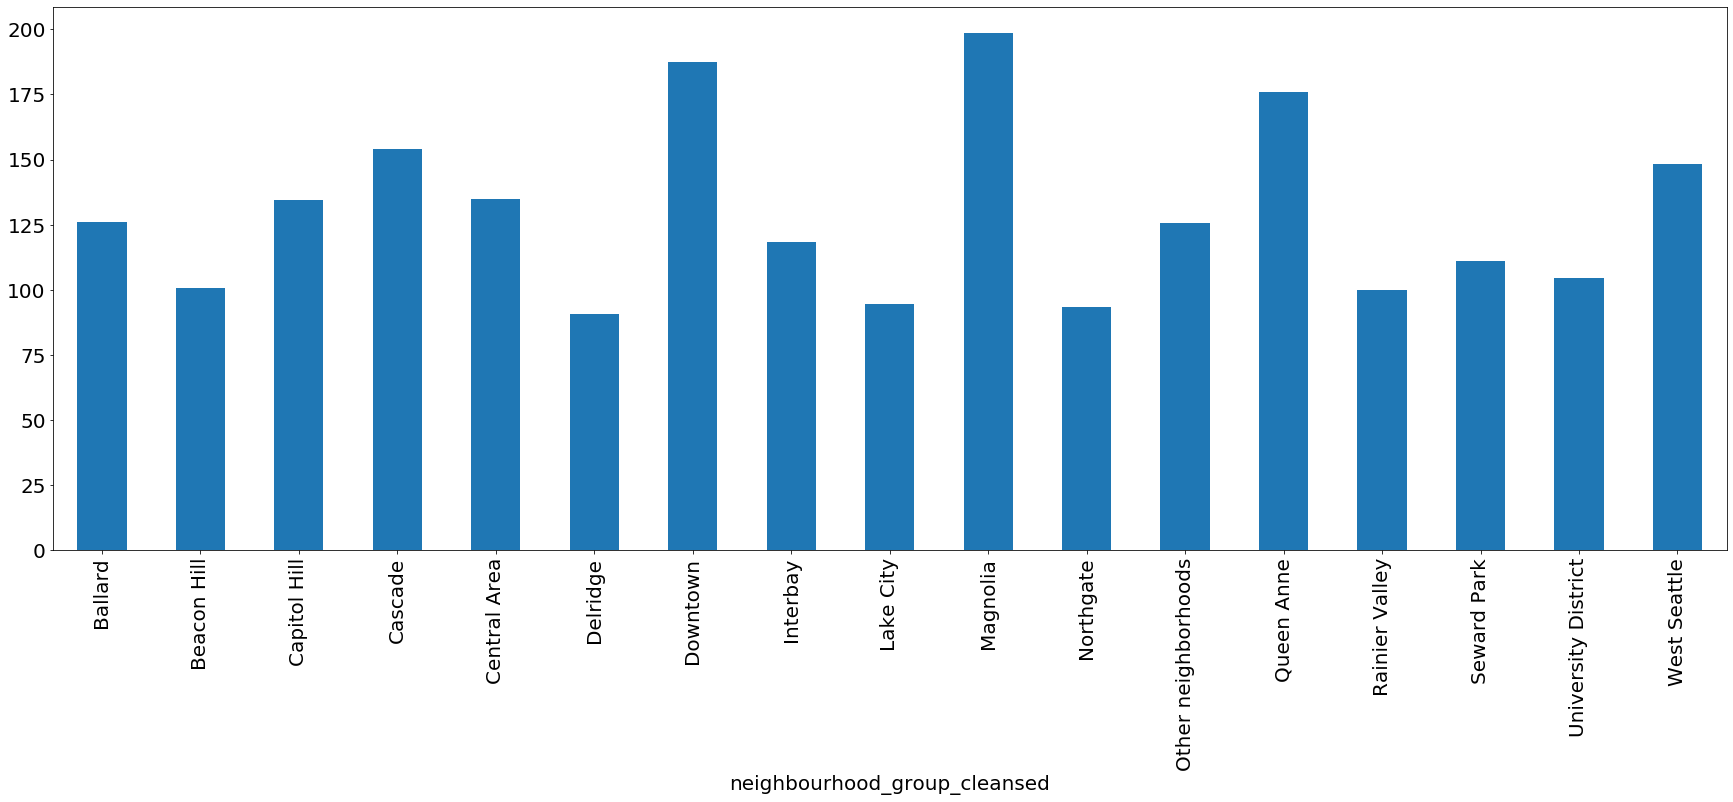

In [143]:
plt.rcParams.update({'font.size': 20})
location_price_mean.plot(kind = 'bar', figsize = (30,10))

To get an idea on # of available listings by neighbourhood

In [144]:
calendar_listings['neighbourhood_group_cleansed'].value_counts()

Other neighborhoods    194661
Capitol Hill           132668
Downtown               125725
Central Area            90556
Queen Anne              66804
Ballard                 58115
West Seattle            51950
Rainier Valley          38914
University District     33148
Beacon Hill             30270
Delridge                21545
Northgate               21105
Lake City               18801
Cascade                 18717
Magnolia                17248
Seward Park             10921
Interbay                 3394
Name: neighbourhood_group_cleansed, dtype: int64

To get an idea of # of bookings by neighbourhood

In [145]:
reviews_listings['neighbourhood_group_cleansed'].value_counts()

Other neighborhoods    17210
Downtown               12606
Capitol Hill           12412
Central Area            8442
Ballard                 7118
Queen Anne              6613
Rainier Valley          4085
West Seattle            3407
Beacon Hill             3355
Delridge                2197
Cascade                 1420
Northgate               1389
University District     1316
Seward Park             1195
Lake City               1028
Magnolia                 933
Interbay                 123
Name: neighbourhood_group_cleansed, dtype: int64

**Summary:**
> **Magnolia** has the highest average price<br />
> **Capitol Hill** has the highest number of listings<br /> 
> **Downtown** has the highest number of listings<br /><br />
> The analysis gives a good idea of the where the demand is for Airbnb in Seattle. Also, it shows that the neighbourhood with the highest average listing price does not mean it is where most people are going. This shows that location is a factor when it comes to pricing

### 2. Timing: Which months have the highest average prices and highest listings?**

To see highest average prices by months, we will group the month data by average prices

In [148]:
month_price_mean = calendar_listings.groupby(calendar_listings['month'],
                                 sort=False)['price'].mean()
month_price_mean

month
January      122.912176
February     124.293927
March        128.644488
April        135.097005
May          139.538183
June         147.473137
July         152.094150
August       150.656594
September    143.255949
October      137.031939
November     135.688738
December     137.251835
Name: price, dtype: float64

To get a simple and easy visualation, a line chart can help

Text(0.5, 1, 'Average Monthly Airbnb Prices in Seattle')

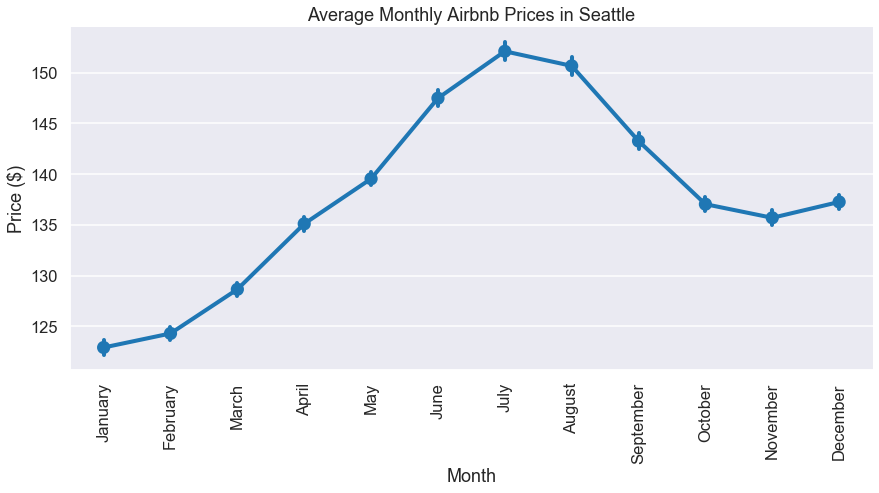

In [153]:
plt.rcParams.update({'font.size': 10})
sb.set_style("darkgrid")
sb.set_context("talk")
plt_price_month = sb.catplot(x='month', y='price', data=calendar_listings, kind="point", height=6, aspect=2.1)
plt_price_month = plt_price_month.set_axis_labels("Month", "Price ($)")
plt_price_month.set_xticklabels(rotation=90)
plt_price_month.ax.set_title("Average Monthly Airbnb Prices in Seattle")

To see the number of listings per month, we create a new dataframe with a subset of the columns. We will then use a combination of GroupBy() to get the counts.

In [163]:
# Getting an idea first of monthly counts
calendar_listings['month'].value_counts()

December     87061
March        83938
October      82438
November     81780
May          79971
September    77246
June         77244
August       76347
April        76037
July         74222
February     73321
January      64937
Name: month, dtype: int64

In [164]:
calendar_listings['month'].describe()

count       934542
unique          12
top       December
freq         87061
Name: month, dtype: object

In [154]:
locations_month = calendar_listings.loc[:,('listing_id',
                                    'date', 
                                    'year', 
                                    'month', 
                                    'neighbourhood_group_cleansed')]

In [157]:
locations_month = locations_month.groupby('neighbourhood_group_cleansed')['month'].value_counts().unstack().fillna(0)

Set the order appropriately so the data is easier to view

In [158]:
# Reorder
locations_month_reordered = locations_month[['January', 'February', 'March', 'April',
                     'May', 'June', 'July', 'August',
                     'September', 'October', 'November', 'December']]
locations_month_reordered

month,January,February,March,April,May,June,July,August,September,October,November,December
neighbourhood_group_cleansed,,,,,,,,,,,,
Ballard,3678,4093,4869,4613,5005,5047,4750,4991,4978,5284,5252,5555
Beacon Hill,2110,2371,2740,2551,2696,2562,2378,2548,2481,2582,2535,2716
Capitol Hill,9265,10348,11634,10439,11018,10905,10575,10806,11113,11966,11872,12727
Cascade,1222,1438,1754,1534,1636,1501,1358,1413,1560,1702,1721,1878
Central Area,5892,7014,7899,7100,7608,7550,7392,7580,7657,8090,8094,8680
Delridge,1450,1724,1888,1799,1872,1830,1750,1748,1789,1883,1856,1956
Downtown,9507,10869,12297,11014,11203,10254,9532,9757,9700,10369,10244,10979
Interbay,275,286,310,271,277,270,276,275,270,279,295,310
Lake City,1361,1416,1665,1582,1651,1584,1444,1495,1545,1703,1650,1705


To get an idea of # of bookings by month

In [160]:
reviews_listings['month'].value_counts()

August       13018
September    11677
July         10503
October       8955
June          8544
November      6665
May           5854
December      5732
April         4233
March         4158
January       2867
February      2643
Name: month, dtype: int64

**Summary:**
> **July** has the highest average price<br />
> **December** has the highest number of listings<br /> 
> **August** has the highest number of listings<br /><br />
> The analysis gives a good idea of the potentially profitable times to rent out an Airbnb in Seattle and for which neighbourhood. This shows that timing is a factor when it comes to pricing.

### 3. Features: Which features affect price?

Prior to starting this analyis, online research was conducted to identify what features are sought after the most.

To summarize the research, the following features were suggested the most:
* The number of people the property accommodates (accommodates)
* The number of bathrooms (bathrooms)
* The number of bedrooms (bedrooms)
* Property type (property_type)
* Number of days available to book in the next 90 days (availability_90)
* Total number of reviews (number_of_reviews)

Location and Timing will be added to the list above as these two subjects were looked at prior to this analysis and were found to impact price. The selection of features in this part of the analysis was based on all the information stated.

**Initial Assessment of Data**<br />
Before diving into this section of the analysis, starting with a heatmap visualization of the *calendar_listings dataset* to get an idea of correlations will help get us started and see if we're on the right track

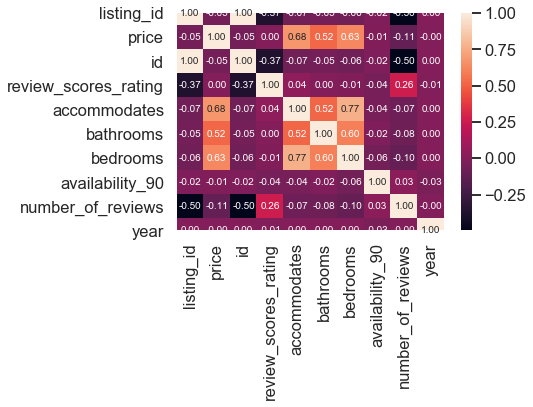

In [185]:
plt.rcParams.update({'font.size': 10})
sb.heatmap(calendar_listings.corr(), annot=True, fmt='.2f')

At a quick glance, the following features have the highest correlations to the price:
* accommodates
* bathrooms
* bedrooms

Based on this, we look to be on the right track.

**Data Preparation**<br />
In this section, we will look to convert all data into numerical values. This is because the modelling techniques / tools (scikit learn) used in this section work better or only support numeric values. 

As a result, additional data prepation steps are required and we will create a new dataframe for this section to avoid impacting the dataframes used in the previous sections.

**feature_set - Data wrangling**

In [217]:
# Drop columns not needed
feature_set = calendar_listings.drop(['listing_id','date','available','id','year'], axis=1)

In [218]:
# Create categorical columns
feature_set_categorical = pd.get_dummies(feature_set, drop_first=False);

In [219]:
# Drop 'price' columns from feature_set_categorical so that it does not impact modeling
feature_set_categorical = feature_set_categorical.drop(['price'], axis=1)

In [220]:
# Check dataframe for null values
feature_set_categorical.isnull().sum().sum()

0

In [221]:
# Check shape to ensure we have sufficient data for training and testing
feature_set_categorical.shape

(934542, 51)

**Modelling: 4 key steps -> Instantiate, Fit, Predict and Score**<br />
We will compare Linear Regression vs Random Forest to see which be a better model for our data

In [222]:
# Set X & y data for models
X = feature_set_categorical
y = feature_set['price']

In [223]:
# Check that X & y shapes are the same
X.shape[0]

934542

In [224]:
# Check that X & y shapes are the same
y.shape[0]

934542

In [225]:
# Create Training and Testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

**Linear Regression**

In [226]:
# Linear Regression
lm_model = LinearRegression(normalize=True)
lm_model.fit(X_train, y_train) 
y_test_preds = lm_model.predict(X_test)
y_train_preds = lm_model.predict(X_train)
test_score = r2_score(y_test, y_test_preds)
train_score = r2_score(y_train, y_train_preds)
print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(train_score, test_score))

The rsquared on the training data was 0.5856150399227675.  The rsquared on the test data was 0.5878651190900441.


In [227]:
def coef_weights(coefficients, X_train):
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(20)

,est_int,coefs,abs_coefs
8,property_type_Boat,1.315066e+14,1.315066e+14
11,property_type_Camper/RV,1.315066e+14,1.315066e+14
21,property_type_Yurt,1.315066e+14,1.315066e+14
10,property_type_Cabin,1.315066e+14,1.315066e+14
16,property_type_Loft,1.315066e+14,1.315066e+14
9,property_type_Bungalow,1.315066e+14,1.315066e+14
13,property_type_Condominium,1.315066e+14,1.315066e+14
6,property_type_Apartment,1.315066e+14,1.315066e+14
7,property_type_Bed & Breakfast,1.315066e+14,1.315066e+14
20,property_type_Treehouse,1.315066e+14,1.315066e+14


**Random Forest**

In [228]:
# RandomForestRegressor
ForestRegressor = RandomForestRegressor(n_estimators=50)
ForestRegressor.fit(X_train, y_train)
y_test_preds = ForestRegressor.predict(X_test)
y_train_preds = ForestRegressor.predict(X_train)

print(r2_score(y_test, y_test_preds))
print(mean_squared_error(y_test, y_test_preds))
print(median_absolute_error(y_test, y_test_preds))

0.9737650628792883
285.2980936670988
0.0


In [229]:
test_score_random_forest = r2_score(y_test, y_test_preds)
train_score_random_forest = r2_score(y_train, y_train_preds)

In [230]:
print("For Random Forest Regressor, the rsquared on the training data was {}.  The rsquared on the test data was {}.".format(train_score_random_forest, test_score_random_forest))

For Random Forest Regressor, the rsquared on the training data was 0.9764350559953533.  The rsquared on the test data was 0.9737650628792883.


In [231]:
coeff_dataframe = pd.DataFrame()

coeff_dataframe['est_int'] = X_train.columns
coeff_dataframe['coeff'] = ForestRegressor.feature_importances_
coeff_dataframe.sort_values('coeff', ascending=False).head(20)

,est_int,coeff
3,bedrooms,0.387838
2,bathrooms,0.166316
4,availability_90,0.077330
1,accommodates,0.073098
5,number_of_reviews,0.066540
0,review_scores_rating,0.046602
28,neighbourhood_group_cleansed_Downtown,0.042353
34,neighbourhood_group_cleansed_Queen Anne,0.014908
8,property_type_Boat,0.010333
6,property_type_Apartment,0.009968


In [232]:
coeff_dataframe.index = coeff_dataframe.est_int

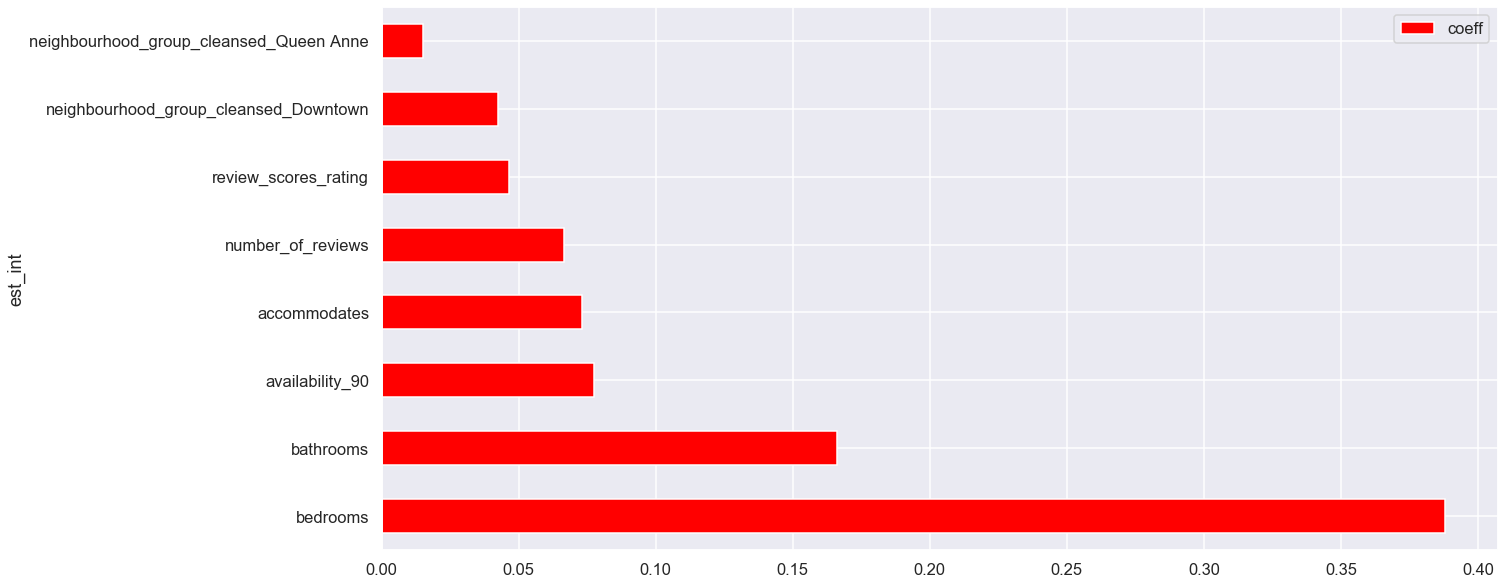

In [233]:
plt.rcParams.update({'font.size': 15})
coeff_dataframe.sort_values('coeff', ascending=False).head(8).plot(kind = 'barh',figsize = (20,10), facecolor='red');

**Summary:**
> In terms of **correlations** with price, the **highest are accommodates, bathrooms and bedrooms**<br />
> **Random Forest** produces a better model for predicting prices. It is quite closely aligned with the correlations heatmap (i.e. bedrooms, bathrooms and accommodates)<br /><br />
> The analysis shows which features (i.e. bedrooms, bathrooms and accommodates) impact price the most and than Random Forest would make a better model than Linear Regression.